In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyvisa
from windfreak import SynthHD
from NRP50S import NRP50S
import time
import tqdm
import csv
from typing import List, Tuple
import datetime


In [2]:
resource_name_power_meter = "USB0::0x0AAD::0x0161::101074::INSTR"
resource_name_windfreak = "COM5"

power_meter = NRP50S(resource_name_power_meter)
synthd = SynthHD(resource_name_windfreak)


In [3]:
display(f"{synthd.model} S/N {synthd.serial_number}")


'SynthHD v1.4 S/N 415'

In [4]:
display(synthd[0].temp_compensation_modes)
display(synthd[0].temp_compensation_mode)

display(synthd[1].temp_compensation_modes)
display(synthd[1].temp_compensation_mode)



('none', 'on set', '1 sec', '10 sec')

'10 sec'

('none', 'on set', '1 sec', '10 sec')

'10 sec'

In [5]:
power_meter._write("UNIT:POW DBM")


# RFout A
## 13.3 GHz power scan

In [6]:
scan_data: List[
    Tuple[
        float,
        float,
    ]
] = []

rf_out = 0

synthd[rf_out].frequency = 13.3e9

power_meter.frequency = synthd[rf_out].frequency

synthd[rf_out].power = 0
synthd[rf_out].enable = True

for shdpower in tqdm.tqdm(np.linspace(-30, 5, 51)):
    synthd[rf_out].power = shdpower
    time.sleep(0.1)
    p = []
    for _ in range(5):
        power_meter._write("RST")
        power_meter.initiate()
        time.sleep(0.5)
        p.append(power_meter.fetch())
    scan_data.append((shdpower, np.mean(p)))

synthd[rf_out].power = -20
synthd[rf_out].enable = False


100%|██████████| 51/51 [02:15<00:00,  2.65s/it]


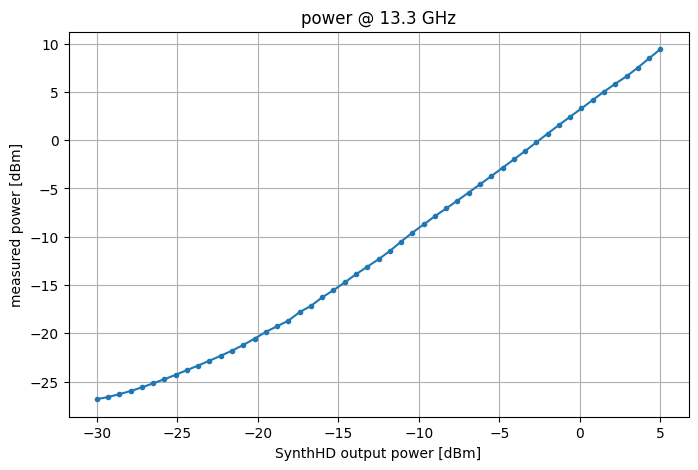

In [7]:
x, det = np.asarray(list(zip(*scan_data)))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, det, ".-")

ax.set_title("power @ 13.3 GHz")
ax.set_xlabel("SynthHD output power [dBm]")
ax.set_ylabel("measured power [dBm]")
ax.grid(True)


## 10 GHz power scan

In [8]:
scan_data: List[
    Tuple[
        float,
        float,
    ]
] = []

rf_out = 0

synthd[rf_out].frequency = 10e9

power_meter.frequency = synthd[rf_out].frequency

synthd[rf_out].power = 0
synthd[rf_out].enable = True

for shdpower in tqdm.tqdm(np.linspace(-30, 5, 51)):
    synthd[rf_out].power = shdpower
    time.sleep(0.1)
    p = []
    for _ in range(5):
        power_meter._write("RST")
        power_meter.initiate()
        time.sleep(0.5)
        p.append(power_meter.fetch())
    scan_data.append((shdpower, np.mean(p)))

synthd[rf_out].power = -20
synthd[rf_out].enable = False


100%|██████████| 51/51 [02:15<00:00,  2.65s/it]


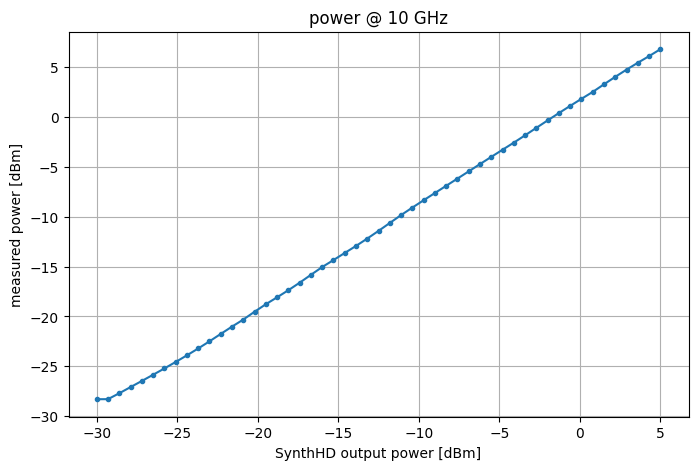

In [9]:
x, det = np.asarray(list(zip(*scan_data)))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, det, ".-")

ax.set_title("power @ 10 GHz")
ax.set_xlabel("SynthHD output power [dBm]")
ax.set_ylabel("measured power [dBm]")
ax.grid(True)


## Frequency and Power scan

In [10]:
scan_data: List[
    Tuple[
        float,
        float,
        float,
    ]
] = []

rf_out = 0

synthd[rf_out].frequency = 10e9
power_meter.frequency = synthd[rf_out].frequency

synthd[rf_out].power = 0
synthd[rf_out].enable = True

for frequency in tqdm.tqdm(np.linspace(10e9, 13.9e9, 51)):
    synthd[rf_out].frequency = frequency
    power_meter.frequency = synthd[rf_out].frequency

    for shdpower in np.linspace(-30, 5, 51):
        synthd[rf_out].power = shdpower
        time.sleep(0.1)
        p = []
        for _ in range(5):
            power_meter._write("RST")
            power_meter.initiate()
            time.sleep(0.5)
            p.append(power_meter.fetch())
        scan_data.append((frequency, shdpower, np.mean(p)))

synthd[rf_out].power = -20
synthd[rf_out].enable = False


100%|██████████| 51/51 [1:55:23<00:00, 135.75s/it]


In [11]:
with open(
    f"{datetime.datetime.now().strftime('%Y_%m_%d')}_synthHDPro_SN{synthd.serial_number}_RFA_scan.csv",
    "w",
    newline="",
) as csvfile:
    writer = csv.writer(csvfile, delimiter=",")
    writer.writerow(["frequency [Hz]", "synthHD Pro power [dBm]", "det power [dBm]"])
    for row in scan_data:
        writer.writerow(row)


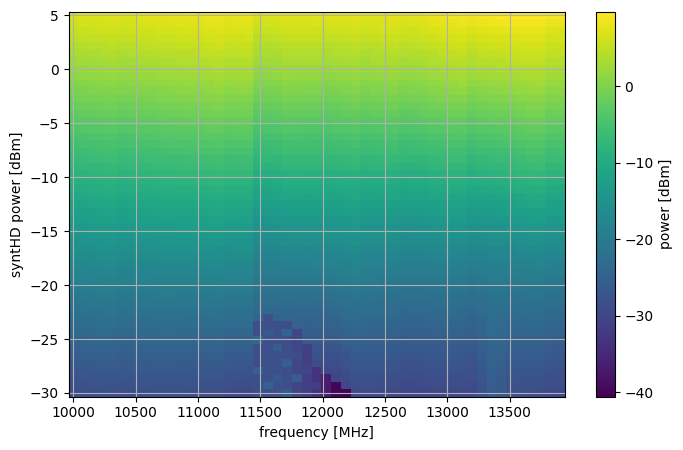

In [12]:
x, y, z = np.asarray(list(zip(*scan_data)))

x = np.reshape(x, (51, 51)) / 1e6
y = np.reshape(y, (51, 51))
z = np.reshape(z, (51, 51))

fig, ax = plt.subplots(figsize=(8, 5))
c = ax.pcolormesh(x, y, z)
ax.set_xlabel("frequency [MHz]")
ax.set_ylabel("syntHD power [dBm]")

cbar = fig.colorbar(c)
cbar.ax.set_ylabel("power [dBm]")
ax.grid(True)


## Monitor SynthHD output Power over time

In [13]:
# wait 10 minutes before staring, to give the SynthHD some time to cool down
synthd[0].power = -25
synthd[1].power = -25
synthd[0].enable = False
synthd[1].enable = False
time.sleep(10 * 60)


In [14]:
scan_data: List[
    Tuple[
        float,
        float,
        float,
    ]
] = []

rf_out = 0

synthd[rf_out].frequency = 13.6e9
power_meter.frequency = synthd[rf_out].frequency

synthd[rf_out].power = 0
synthd[rf_out].enable = True

dt = 10

datetime_start = datetime.datetime.now()
time_start = time.time()

for _ in tqdm.tqdm(range(int(24 * 60 * 60 / dt))):
    p = []
    for _ in range(5):
        power_meter._write("RST")
        power_meter.initiate()
        time.sleep(0.5)
        p.append(power_meter.fetch())
    scan_data.append(
        (
            datetime.datetime.now(),
            time.time() - time_start,
            np.mean(p),
            synthd.temperature,
        )
    )
    time.sleep(8)

synthd[rf_out].power = -20
synthd[rf_out].enable = False


100%|██████████| 8640/8640 [25:21:40<00:00, 10.57s/it]   


In [18]:
timestamp_str = datetime_start.isoformat(timespec="seconds").replace(":","_")
with open(
    f"{timestamp_str}_synthHDPro_SN{synthd.serial_number}_RFA_time_monitoring.csv",
    "w",
    newline="",
) as csvfile:
    writer = csv.writer(csvfile, delimiter=",")
    writer.writerow(
        ["timestamp [isoformat]", "time [s]", "det power [dBm]", "temperature [C]"]
    )
    for row in scan_data:
        row = list(row)
        row[0] = row[0].isoformat(timespec="seconds")
        writer.writerow(row)


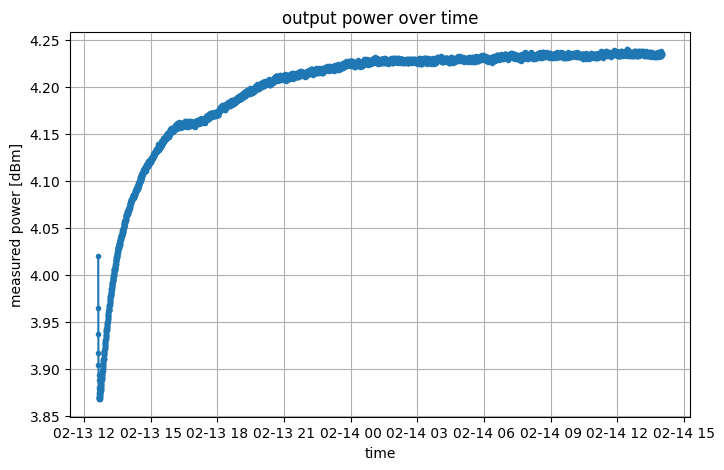

In [22]:
timestamps, ts, det, temp = np.asarray(list(zip(*scan_data)))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(timestamps, det, ".-")

ax.set_title("output power over time")
ax.set_xlabel("time")
ax.set_ylabel("measured power [dBm]")
ax.grid(True)


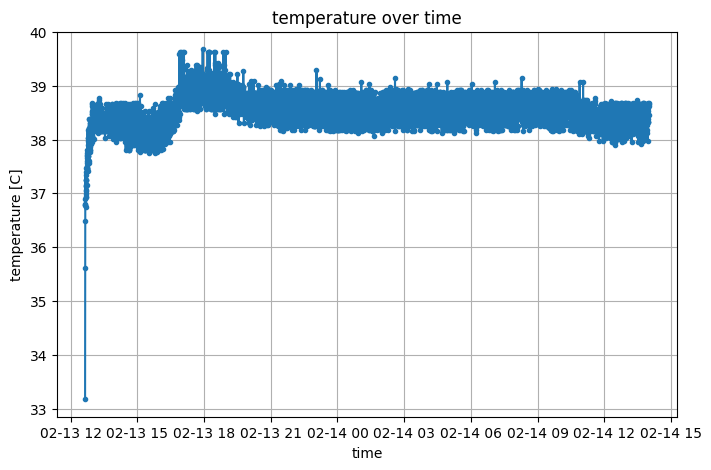

In [21]:
timestamps, ts, det, temp = np.asarray(list(zip(*scan_data)))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(timestamps, temp, ".-")

ax.set_title("temperature over time")
ax.set_xlabel("time")
ax.set_ylabel("temperature [C]")
ax.grid(True)


# RFout B
## 13.3 GHz power scan

In [24]:
scan_data: List[
    Tuple[
        float,
        float,
    ]
] = []

rf_out = 1

synthd[rf_out].frequency = 13.3e9

power_meter.frequency = synthd[rf_out].frequency

synthd[rf_out].power = 0
synthd[rf_out].enable = True

for shdpower in tqdm.tqdm(np.linspace(-30, 5, 51)):
    synthd[rf_out].power = shdpower
    time.sleep(0.1)
    p = []
    for _ in range(5):
        power_meter._write("RST")
        power_meter.initiate()
        time.sleep(0.5)
        p.append(power_meter.fetch())
    scan_data.append((shdpower, np.mean(p)))

synthd[rf_out].power = -20
synthd[rf_out].enable = False


 24%|██▎       | 12/51 [00:31<01:43,  2.64s/it]

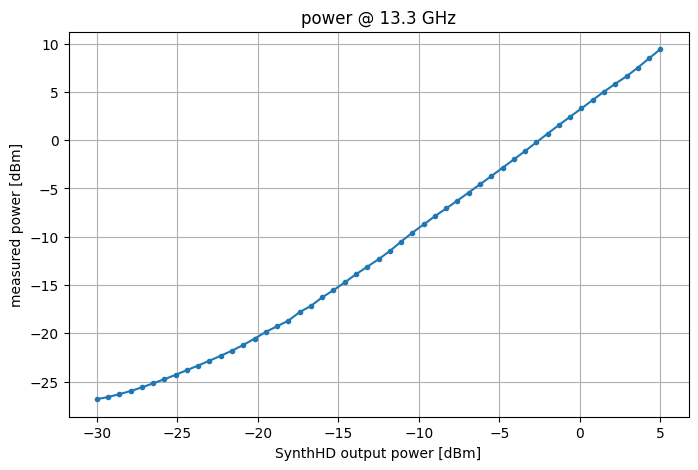

In [ ]:
x, det = np.asarray(list(zip(*scan_data)))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, det, ".-")

ax.set_title("power @ 13.3 GHz")
ax.set_xlabel("SynthHD output power [dBm]")
ax.set_ylabel("measured power [dBm]")
ax.grid(True)


## 10 GHz power scan

In [ ]:
scan_data: List[
    Tuple[
        float,
        float,
    ]
] = []

rf_out = 1

synthd[rf_out].frequency = 10e9

power_meter.frequency = synthd[rf_out].frequency

synthd[rf_out].power = 0
synthd[rf_out].enable = True

for shdpower in tqdm.tqdm(np.linspace(-30, 5, 51)):
    synthd[rf_out].power = shdpower
    time.sleep(0.1)
    p = []
    for _ in range(5):
        power_meter._write("RST")
        power_meter.initiate()
        time.sleep(0.5)
        p.append(power_meter.fetch())
    scan_data.append((shdpower, np.mean(p)))

synthd[rf_out].power = -20
synthd[rf_out].enable = False


100%|██████████| 51/51 [02:15<00:00,  2.65s/it]


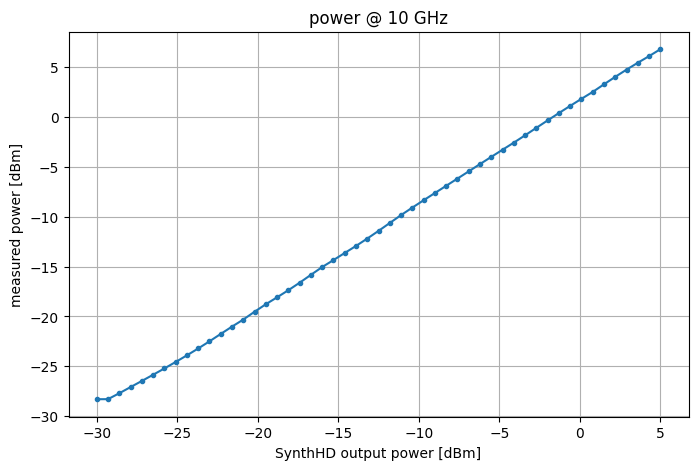

In [ ]:
x, det = np.asarray(list(zip(*scan_data)))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, det, ".-")

ax.set_title("power @ 10 GHz")
ax.set_xlabel("SynthHD output power [dBm]")
ax.set_ylabel("measured power [dBm]")
ax.grid(True)


## Frequency and Power scan

In [23]:
scan_data: List[
    Tuple[
        float,
        float,
        float,
    ]
] = []

rf_out = 1

synthd[rf_out].frequency = 10e9
power_meter.frequency = synthd[rf_out].frequency

synthd[rf_out].power = 0
synthd[rf_out].enable = True

for frequency in tqdm.tqdm(np.linspace(10e9, 13.9e9, 51)):
    synthd[rf_out].frequency = frequency
    power_meter.frequency = synthd[rf_out].frequency

    for shdpower in np.linspace(-30, 5, 51):
        synthd[rf_out].power = shdpower
        time.sleep(0.1)
        p = []
        for _ in range(5):
            power_meter._write("RST")
            power_meter.initiate()
            time.sleep(0.5)
            p.append(power_meter.fetch())
        scan_data.append((frequency, shdpower, np.mean(p)))

synthd[rf_out].power = -20
synthd[rf_out].enable = False


  0%|          | 0/51 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
with open(
    f"{datetime.datetime.now().strftime('%Y_%m_%d')}_synthHDPro_SN{synthd.serial_number}_RFB_scan.csv",
    "w",
    newline="",
) as csvfile:
    writer = csv.writer(csvfile, delimiter=",")
    writer.writerow(["frequency [Hz]", "synthHD Pro power [dBm]", "det power [dBm]"])
    for row in scan_data:
        writer.writerow(row)


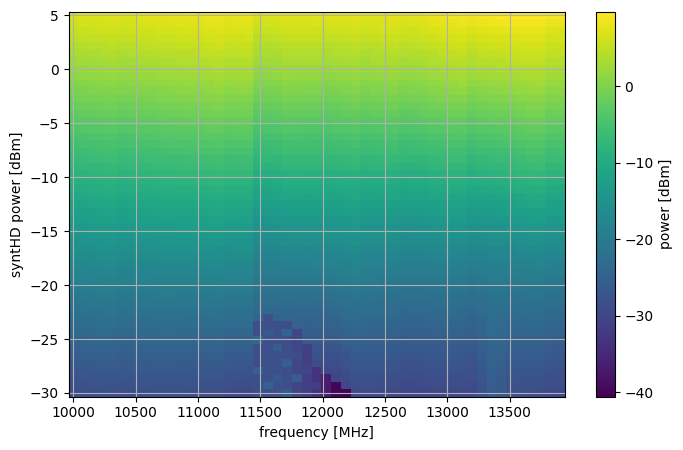

In [ ]:
x, y, z = np.asarray(list(zip(*scan_data)))

x = np.reshape(x, (51, 51)) / 1e6
y = np.reshape(y, (51, 51))
z = np.reshape(z, (51, 51))

fig, ax = plt.subplots(figsize=(8, 5))
c = ax.pcolormesh(x, y, z)
ax.set_xlabel("frequency [MHz]")
ax.set_ylabel("syntHD power [dBm]")

cbar = fig.colorbar(c)
cbar.ax.set_ylabel("power [dBm]")
ax.grid(True)


## Monitor SynthHD output Power over time

In [ ]:
# wait 10 minutes before staring, to give the SynthHD some time to cool down
synthd[0].power = -25
synthd[1].power = -25
synthd[0].enable = False
synthd[1].enable = False
time.sleep(10 * 60)


In [ ]:
scan_data: List[
    Tuple[
        float,
        float,
        float,
    ]
] = []

rf_out = 1

synthd[rf_out].frequency = 13.6e9
power_meter.frequency = synthd[rf_out].frequency

synthd[rf_out].power = 0
synthd[rf_out].enable = True

dt = 10

datetime_start = datetime.datetime.now()
time_start = time.time()

for _ in tqdm.tqdm(range(int(24 * 60 * 60 / dt))):
    p = []
    for _ in range(5):
        power_meter._write("RST")
        power_meter.initiate()
        time.sleep(0.5)
        p.append(power_meter.fetch())
    scan_data.append(
        (
            datetime.datetime.now(),
            time.time() - time_start,
            np.mean(p),
            synthd.temperature,
        )
    )
    time.sleep(8)

synthd[rf_out].power = -20
synthd[rf_out].enable = False


100%|██████████| 8640/8640 [25:21:40<00:00, 10.57s/it]   


In [ ]:
timestamp_str = datetime_start.isoformat(timespec="seconds").replace(":","_")
with open(
    f"{timestamp_str}_synthHDPro_SN{synthd.serial_number}_RFB_time_monitoring.csv",
    "w",
    newline="",
) as csvfile:
    writer = csv.writer(csvfile, delimiter=",")
    writer.writerow(
        ["timestamp [isoformat]", "time [s]", "det power [dBm]", "temperature [C]"]
    )
    for row in scan_data:
        row = list(row)
        row[0] = row[0].isoformat(timespec="seconds")
        writer.writerow(row)


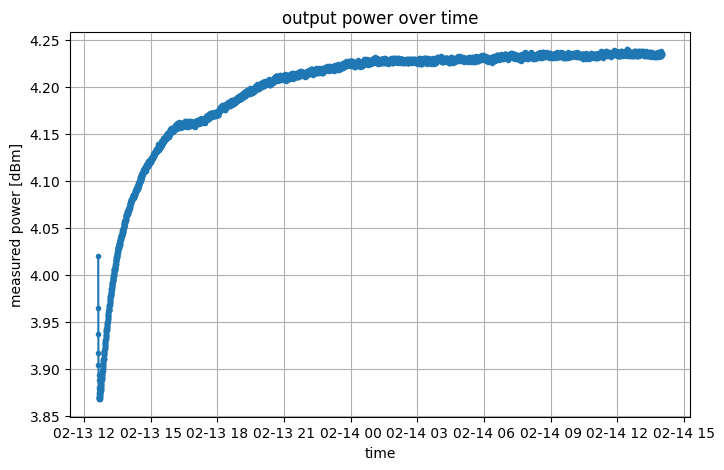

In [ ]:
timestamps, ts, det, temp = np.asarray(list(zip(*scan_data)))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(timestamps, det, ".-")

ax.set_title("output power over time")
ax.set_xlabel("time")
ax.set_ylabel("measured power [dBm]")
ax.grid(True)


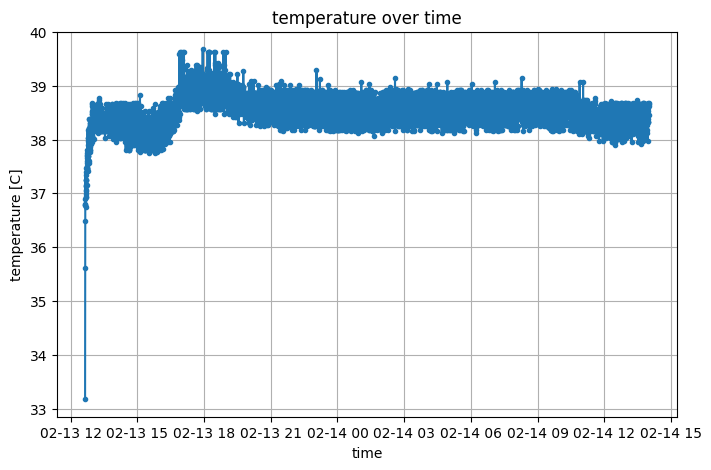

In [ ]:
timestamps, ts, det, temp = np.asarray(list(zip(*scan_data)))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(timestamps, temp, ".-")

ax.set_title("temperature over time")
ax.set_xlabel("time")
ax.set_ylabel("temperature [C]")
ax.grid(True)
